# Data Browser

View sample images, labels, and summary statistics from datasets 

In [1]:
from dataloaders import make_dataset
from dataloaders import custom_transforms as tr
from dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

from types import SimpleNamespace

### Set these variables as desired to load different datasets.

In [4]:
dataset_name = 'cityscapes'

#All figures will be saved with the following prefix
figure_prefix = "figures/cityscapes_"

# Dataset directory root
root = 'datasets/cityscapes/'

# Default configuration file
cfg_file = 'configs/cityscapes_rgbd.yaml'

# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.GT_MODE', 'gtFine',
            'DATASET.CITYSCAPES.TRAIN_SET', 'train']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [5]:
def display_grid(images, labels):
    
    n = len(labels)
    plt.figure(figsize=(16, 8))
    
#     m = math.ceil(n/4)
    for ii in range(n):
        if images[ii] is not None:
            plt.subplot(1, n, ii+1)
            plt.imshow(images[ii])
            plt.title(labels[ii])
            plt.axis('off')

In [6]:
def display_labels(colors, names):
    # for i = range(10)
    fig = plt.figure(figsize=(2, 5))
    ax = plt.subplot(1,2,1)
    plt.imshow(colors[:, :10, :].transpose((1,0,2)))
    plt.yticks(range(10), names[:10])
    ax.get_xaxis().set_visible(False)

    ax = plt.subplot(1,2,2)
    plt.imshow(colors[:, 10:, :].transpose((1,0,2)))
    plt.yticks(range(9), names[10:])
    ax.yaxis.tick_right()
    ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    fig.savefig(figure_prefix + 'segmentation_legend.eps', format='eps', dpi=300)
    

Using RGB-D input
Found 500 val images
['datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png']
['datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png']
['datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_001016_leftImg8bit.png']
['datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png']
['datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_001751_leftImg8bit.png']


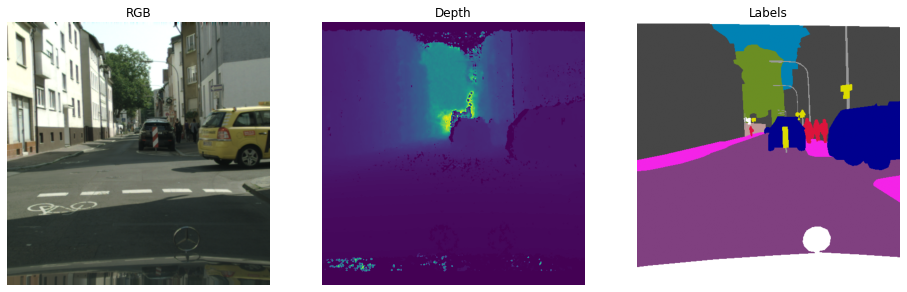

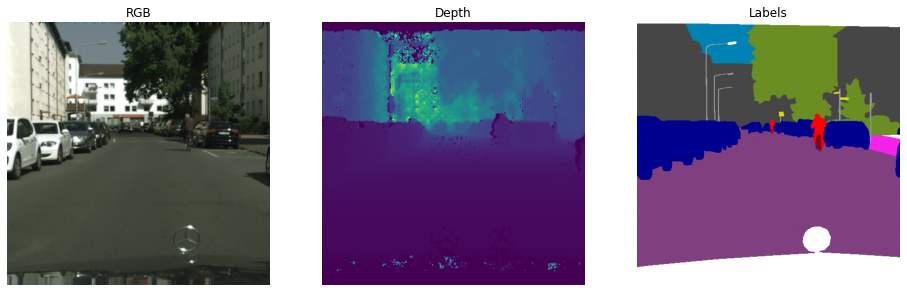

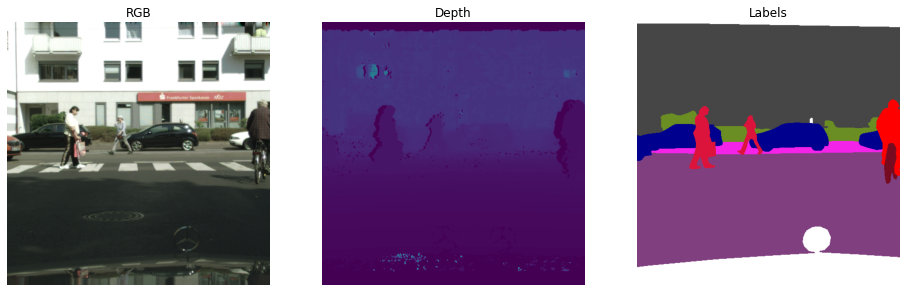

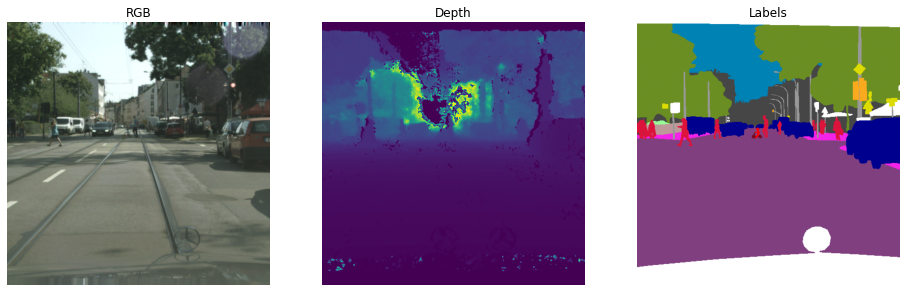

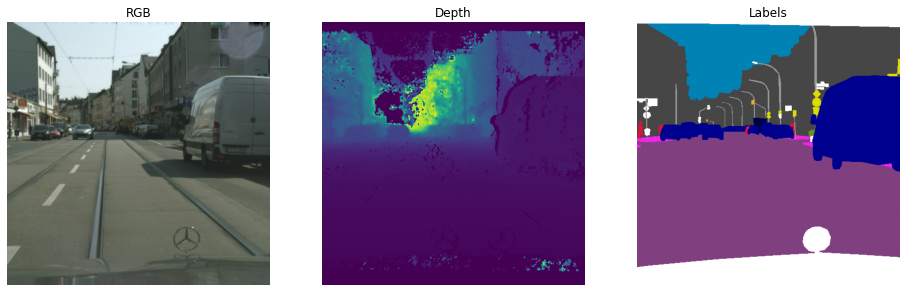

In [7]:
#Same as main method of dataloaders.datasets.coco
val = make_dataset(cfg, split='val')

dataloader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img_tmp = val.loader.invert_normalization(sample['image'].squeeze())
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset=dataset_name)
        
        imgs = [img_tmp[:,:,:3], img_tmp[:,:,3:].squeeze(), segmap]
        labels = ['RGB', 'Depth', 'Labels']
        display_grid(imgs, labels)

    print(sample["id"])
    if ii == 4:
        break

plt.show(block=True)

There is a fixed semantic segmentation labels color palette for each dataset. Use deeplab3.dataloaders.get_label_colors to retrieve the color palette.

<ipython-input-6-980f2cbf258b>:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


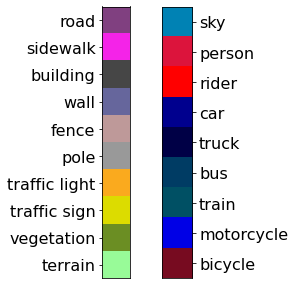

In [9]:
from dataloaders import get_label_colors

font = {'size'   : 16}

matplotlib.rc('font', **font)

#Class colors for reference
names = [x.replace('_', ' ') for x in val.loader.class_names]
colors = np.expand_dims(get_label_colors(cfg), 0)

display_labels(colors,names)

## Pixel Intensity Histograms

In [10]:
from dataloaders.utils import sample_distribution

In [11]:
def plot_distribution(a_list, bins, percent=False):
    ax = plt.figure()
    bin_middle = np.array([(bins[x] + bins[x + 1]) / 2.0 for x in range(len(bins) - 1)])
    for a in a_list:
        n = np.histogram(a, bins=bins)[0]
        if percent:
            n = n / np.sum(n)
        # y = scipy.stats.norm.pdf(b, 0, 1)
        plt.plot(bin_middle[np.nonzero(n)], n[np.nonzero(n)])

    return ax

In [12]:
dist_train = sample_distribution(make_dataset(cfg, split='train'), n=100)

Using RGB-D input
Found 2975 train images


100it [00:33,  3.01it/s]


### RGB

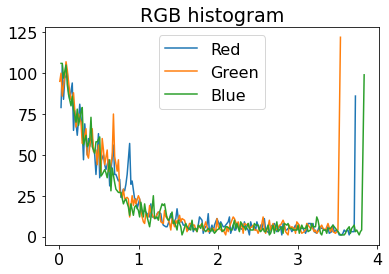

In [26]:
bins = np.linspace(0,4, num=256)
plot_distribution([dist_train['samples'][:, 0],
                  dist_train['samples'][:, 1],
                  dist_train['samples'][:, 2]], bins)
plt.title("RGB histogram")
plt.legend(["Red", "Green", "Blue"])
plt.show()

### Measured Depth

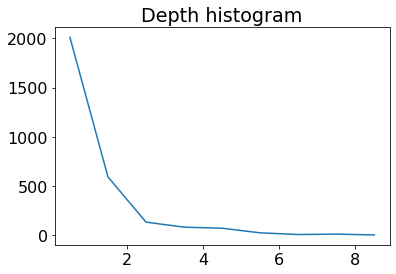

In [14]:
bins = np.linspace(0,255, num=256)
plot_distribution([dist_train['samples'][:, 3:]], bins)
plt.title("Depth histogram")
plt.show()

In [15]:
print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_train['mean'], 
                                         dist_train['std']))

cityscapes mean: [-0.14536014 -0.17488128 -0.17706197 -0.05930319] 
 	 std: [1.02645243 1.06987317 1.04382266 0.92116703]


### Synthetic Depth

Using RGB-D input


0it [00:00, ?it/s]

Found 19997 train_extra images


100it [00:33,  3.03it/s]


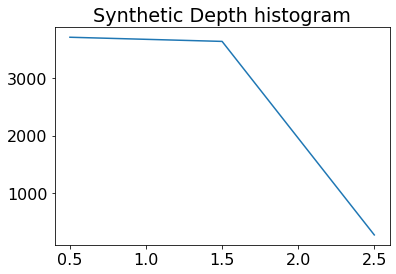

cityscapes mean: [ 1.85160234e-02 -2.04291547e-04 -1.12156540e-02  6.87624031e-01] 
 	 std: [1.08203687 1.12084543 1.11320355 0.80934466]


In [16]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'VNL_Monocular']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_synth = sample_distribution(make_dataset(cfg, split='train'), n=100)

bins = np.linspace(0,255, num=256)
plot_distribution([dist_synth['samples'][:, 3:]], bins)
plt.title("Synthetic Depth histogram")
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_synth['mean'], 
                                         dist_synth['std']))

### Completed Depth

Using RGB-D input


0it [00:00, ?it/s]

Found 19997 train_extra images


100it [00:35,  2.79it/s]


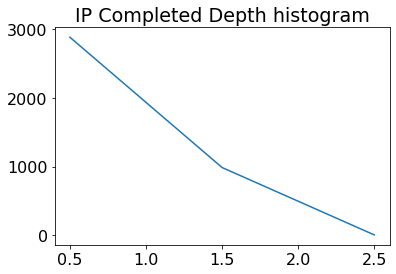

cityscapes mean: [-0.00183898 -0.01805775 -0.02815683 -0.01046349] 
 	 std: [1.04902548 1.08516554 1.074707   0.67712715]


In [17]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'completed_depth']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_lidar = sample_distribution(make_dataset(cfg, split='train'), n=100)

bins = np.linspace(0,255, num=256)
plot_distribution([dist_lidar['samples'][:, 3:]], bins)
plt.title("IP Completed Depth histogram")
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_lidar['mean'], 
                                         dist_lidar['std']))

### HHA

Using RGB HHA input


0it [00:00, ?it/s]

Found 19997 train_extra images


100it [00:35,  2.81it/s]


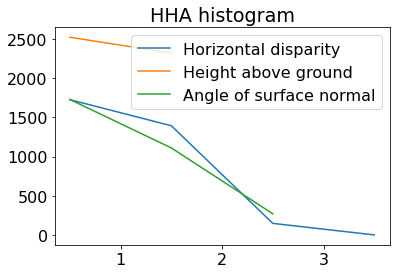

cityscapes mean: [ 0.01135813 -0.01569655 -0.0453545  -0.28899385 -0.2042651  -0.3992937 ] 
 	 std: [1.00212443 1.04045019 1.0317775  0.98162009 1.13071867 1.09152646]


In [18]:
# Extra configurations
cfg_list = ['DATASET.CITYSCAPES.DEPTH_DIR', 'HHA',
           'DATASET.MODE', 'RGB_HHA']

# Load configuration
from dataloaders.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_file)
cfg.merge_from_list(['DATASET.ROOT', root])
cfg.merge_from_list(cfg_list)

dist_hha = sample_distribution(make_dataset(cfg, split='train'), n=100)

bins = np.linspace(0,255, num=256)
plot_distribution([dist_hha['samples'][:, 3], dist_hha['samples'][:, 4], dist_hha['samples'][:, 5]], bins)
plt.title("HHA histogram")
plt.legend(["Horizontal disparity", "Height above ground", "Angle of surface normal"])
plt.show()

print("{} mean: {} \n \t std: {}".format(dataset_name, 
                                         dist_hha['mean'], 
                                         dist_hha['std']))

In [ ]:
dist_train

In [ ]:
dist_train['samples'][:, 2].max()

{'mean': array([-0.14536014, -0.17488128, -0.17706197, -0.05930319]),
 'std': array([1.02645243, 1.06987317, 1.04382266, 0.92116703]),
 'max': array([3.73157883, 3.53157902, 3.83243227, 8.78962898]),
 'median': array([-0.27254903, -0.26615059, -0.30111289, -0.41969903]),
 'samples': array([[ 0.07832824, -0.0184726 ,  0.12284055, -0.49741092],
        [ 0.01640873, -0.05975226,  0.03804988, -0.42263722],
        [ 0.01640873, -0.05975226,  0.03804988, -0.49465621],
        ...,
        [-0.60278636, -0.51382869, -0.64027554, -0.15695463],
        [ 0.01640873,  0.02280707, -0.1739268 , -0.41126484],
        [-0.02487094,  0.1672859 , -0.11033379, -0.15304445]])}

In [25]:
dist_train['samples'][:, 2].max()

3.832432270050049